In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
plt.style.use('ggplot')

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')




In [2]:
# Read in data 
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Quick Exploratory Data Analysis

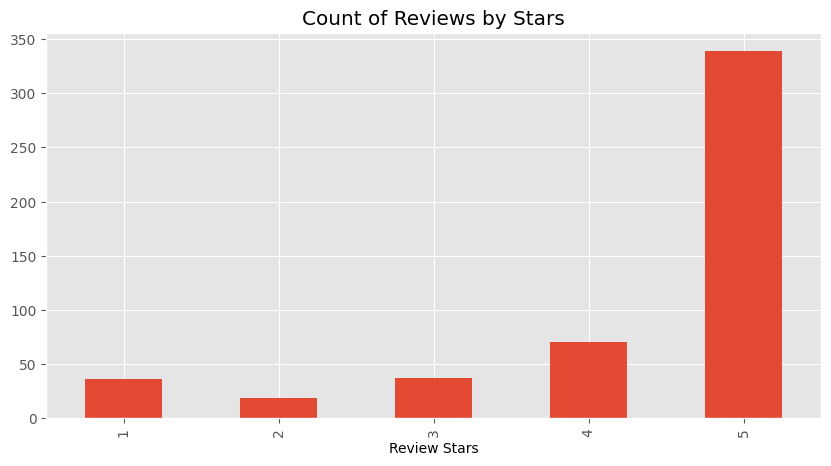

In [4]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', figsize=(10,5) )
ax.set_xlabel('Review Stars')
plt.show()

Basic NLTK


In [5]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [7]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [8]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


VADER Sentiment Scoring

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 

sia = SentimentIntensityAnalyzer()

Running the polarity on the entitre dataset

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']  # Assuming the correct column name is 'Id'
    res[myid] = sia.polarity_scores(text)
    




In [11]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [12]:
#now we have sentiment score and meta data
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Plot VADER results

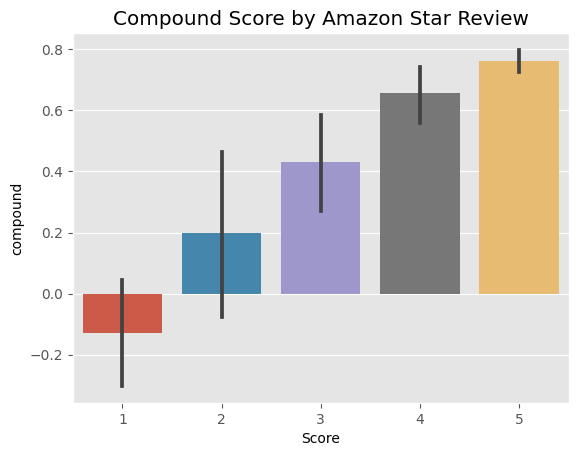

In [13]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

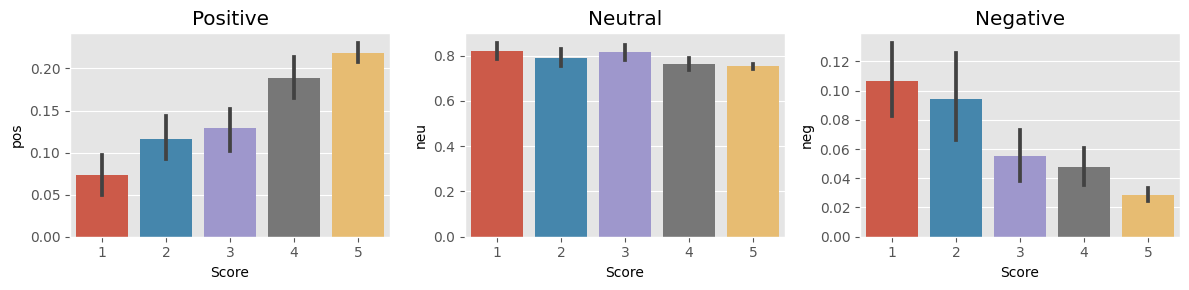

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Roberta Pretrained Model

In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
from transformers import TFAutoModelForSequenceClassification
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
import torch


In [ ]:
encoded_text = tokenizer(example, return_tensors='tf')
output = model(**encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]

}
print(scores_dict)

In [18]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='tf')
    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict



In [ ]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']  # Assuming the correct column name is 'Id'
        
        # Perform sentiment analysis using VADER
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}

        # Perform sentiment analysis using Roberta
        roberta_result = polarity_scores_roberta(text)
        
        # Combine VADER and Roberta results
        both = {**vader_result_rename, **roberta_result}
        
        # Store results in the 'res' dictionary
        res[myid] = both
    except Exception as e:
        print(f'Error for id {myid}: {e}')

# 'res' now contains sentiment analysis results for each text


In [21]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')


In [22]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.303590,0.307304,0.389107,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.325590,0.312668,0.361741,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.333069,0.283825,0.383107,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.331186,0.283847,0.384967,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.275236,0.304620,0.420144,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Compare Scores btw models


In [ ]:
results_df.columns

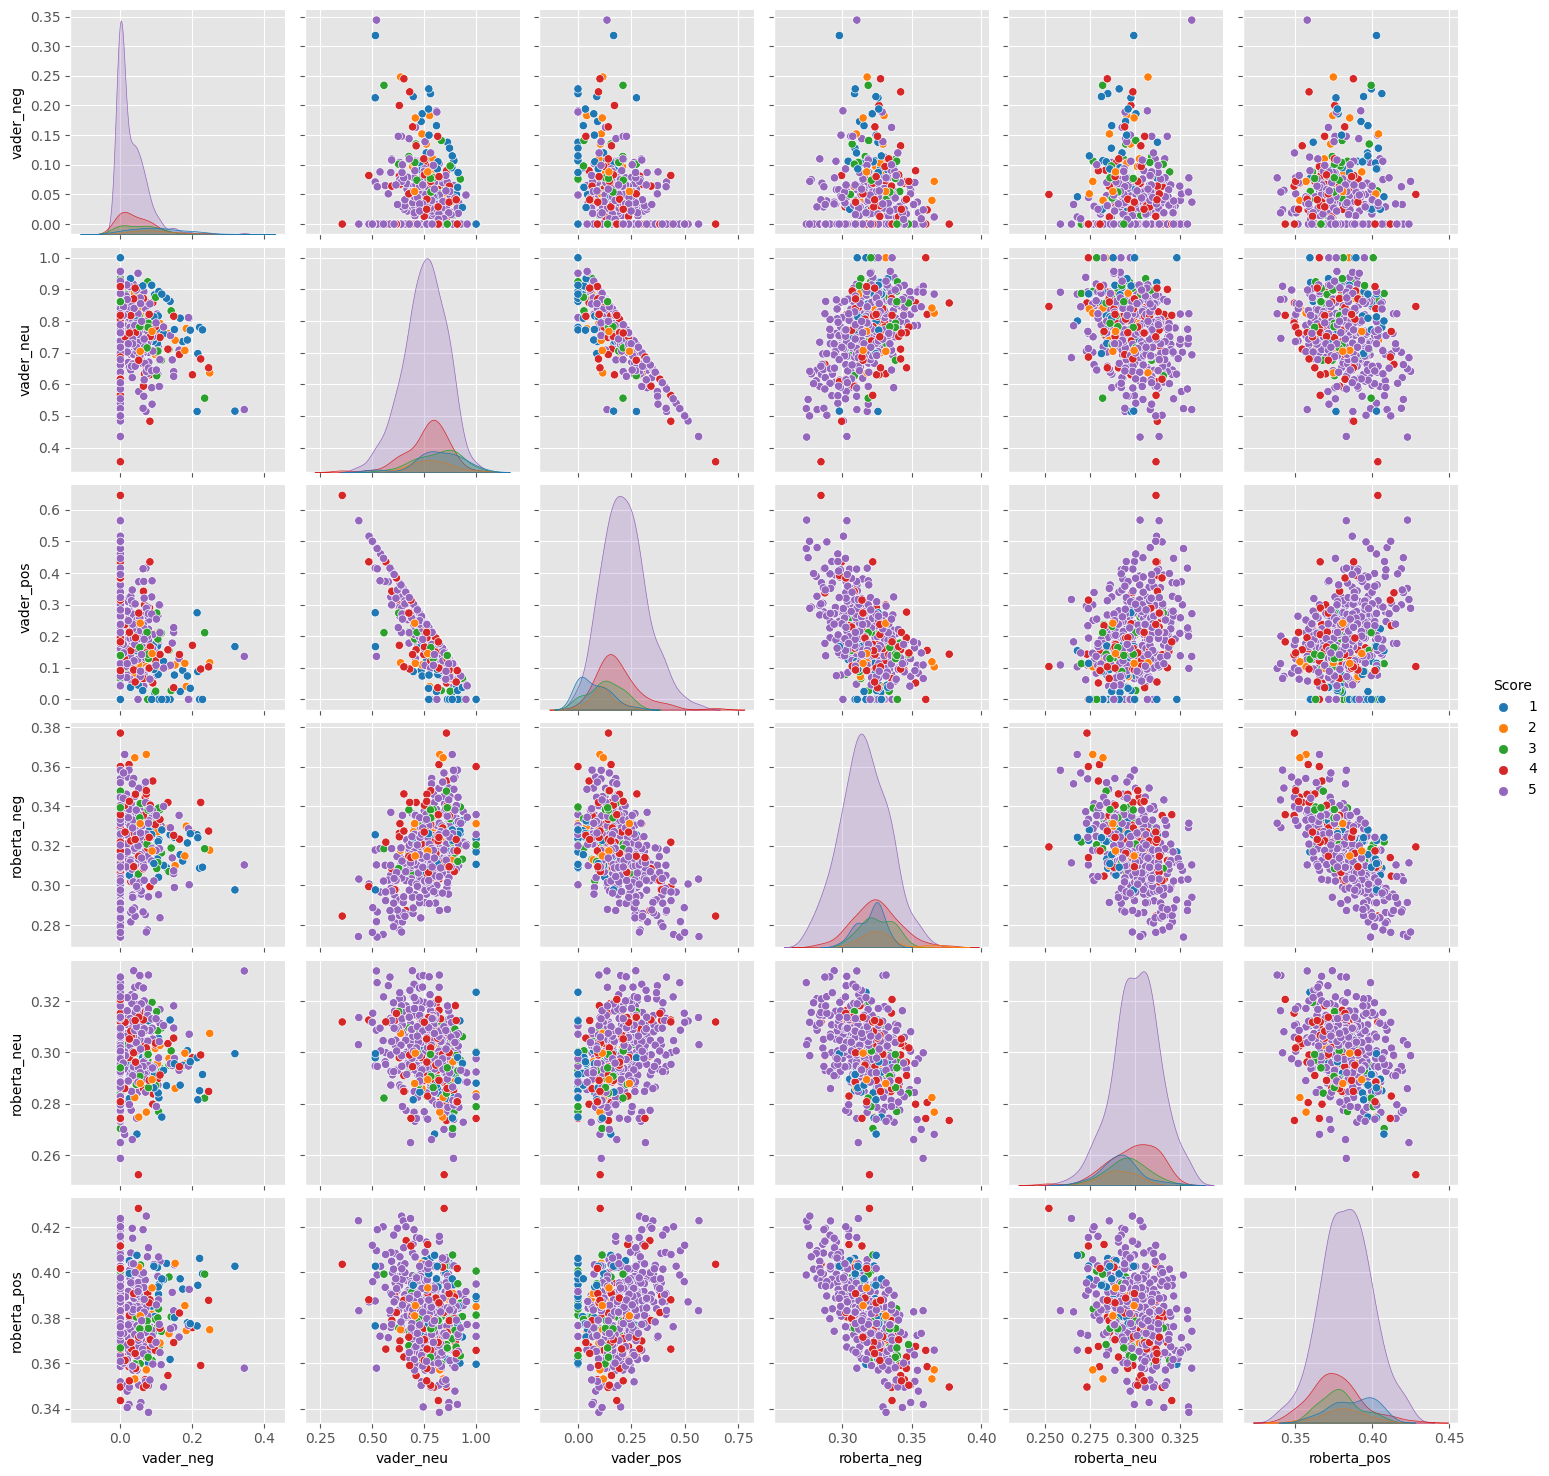

In [24]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'], hue='Score', palette='tab10')
plt.show()

In [26]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [27]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Serveice delivery with the seller was excellent. The product was not. Will not order again. Bad taste. Iam not sure if it was old or that how it tastes. I throw it right away, i coudl not drink it.'

In [28]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

# negative sentiment 5-start review

'Twizzlers, Strawberry my childhood favorite candy, made in Lancaster Pennsylvania by Y & S Candies, Inc. one of the oldest confectionery Firms in the United States, now a Subsidiary of the Hershey Company, the Company was established in 1845 as Young and Smylie, they also make Apple Licorice Twists, Green Color and Blue Raspberry Licorice Twists, I like them all<br /><br />I keep it in a dry cool place because is not recommended it to put it in the fridge. According to the Guinness Book of Records, the longest Licorice Twist ever made measured 1.200 Feet (370 M) and weighted 100 Pounds (45 Kg) and was made by Y & S Candies, Inc. This Record-Breaking Twist became a Guinness World Record on July 19, 1998. This Product is Kosher! Thank You'

In [29]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

# negative sentiment 5-start review

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [1]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [2]:
sent_pipeline('i love sentiment analysis')

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [3]:
sent_pipeline('i do not love sentiment analysis')

[{'label': 'NEGATIVE', 'score': 0.9959374666213989}]

In [4]:
input_text = input("Enter the text you want to analyze: ")
sentiment = sent_pipeline(input_text)
print("Sentiment:", sentiment[0]['label'])

Sentiment: NEGATIVE


With GUI representation

In [6]:
import tkinter as tk
from tkinter import messagebox
from transformers import pipeline

# Create a sentiment analysis pipeline
sent_pipeline = pipeline("sentiment-analysis")

def analyze_sentiment():
    input_text = text_entry.get("1.0", "end-1c")  # Get the text from the text box
    if input_text.strip() == "":
        messagebox.showinfo("Error", "Please enter text for analysis.")
    else:
        sentiment = sent_pipeline(input_text)
        result_label.config(text="Sentiment: " + sentiment[0]['label'])

# Create the main window
root = tk.Tk()
root.title("Sentiment Analysis")

# Create UI components
text_label = tk.Label(root, text="Enter text for sentiment analysis:")
text_label.pack()

text_entry = tk.Text(root, height=5, width=40)
text_entry.pack()

analyze_button = tk.Button(root, text="Analyze Sentiment", command=analyze_sentiment)
analyze_button.pack()

result_label = tk.Label(root, text="")
result_label.pack()

# Start the GUI event loop
root.mainloop()


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
